In [1]:
!pip install swig
!pip install "gymnasium[box2d]"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Episode   1 | reward   -10.7 | step    500/100000 | buffer    500 | mean_actions [-0.00, 0.53, 0.49] | std_actions [0.58, 0.28, 0.28]
Episode   2 | reward   -13.0 | step   1000/100000 | buffer   1000 | mean_actions [+0.01, 0.50, 0.48] | std_actions [0.57, 0.29, 0.29]
Episode   3 | reward   -11.4 | step   1500/100000 | buffer   1500 | mean_actions [-0.04, 0.51, 0.51] | std_actions [0.58, 0.28, 0.29]
Episode   4 | reward   -15.2 | step   2000/100000 | buffer   2000 | mean_actions [+0.01, 0.51, 0.50] | std_actions [0.59, 0.29, 0.29]
Episode   5 | reward   -12.7 | step   2500/100000 | buffer   2500 | mean_actions [-0.04, 0.49, 0.50] | std_actions [0.57, 0.29, 0.28]
Episode   6 | reward   -15.2 | step   3000/100000 | buffer   3000 | mean_actions [-0.03, 0.50, 0.50] | std_actions [0.56, 0.29, 0.29]
Episode   7 | reward   -19.9 | step   3500/100000 | buffer   3500 | mean_actions [-0.00, 0.51, 0.50] | std_actions [0.58, 0.29, 0.28]
Episode   8 | reward   -17.0 | step   4000/100000 | buffer   4

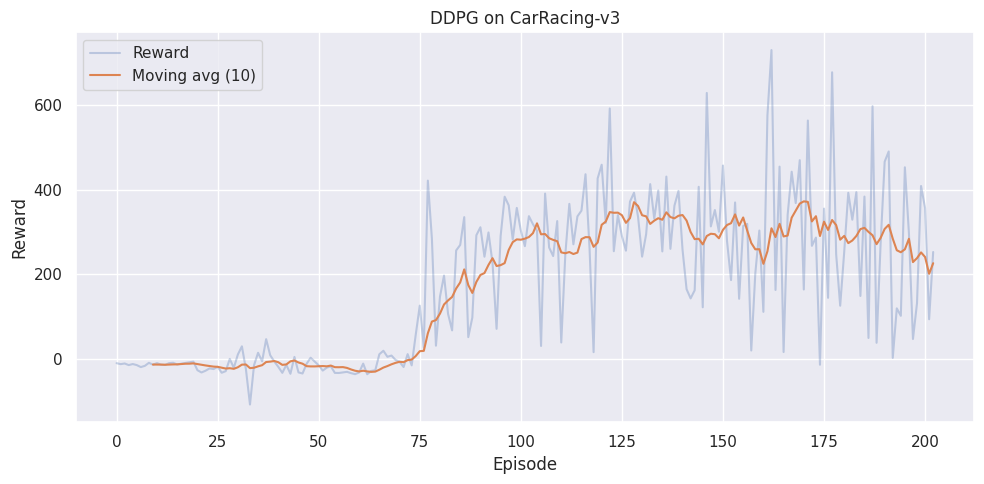

GIF saved


In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import random
import copy
from collections import deque
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns
sns.set_theme()

from gymnasium.wrappers import (
    GrayscaleObservation,
    ResizeObservation,
    FrameStackObservation,
)


# CONFIG

ENV_NAME = "CarRacing-v3"
SEED = 42

TOTAL_STEPS = 100_000
START_STEPS = 10_000
MAX_EPISODE_STEPS = 500

BATCH_SIZE = 128
BUFFER_SIZE = 20_000

GAMMA = 0.99
TAU = 0.005

LR_ACTOR = 1e-4
LR_CRITIC = 1e-3

GRAD_CLIP_NORM = 1.5

ACTIONS_DIM = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_DIR = "/content/drive/MyDrive/car_racing_v3_ddpg"
os.makedirs(SAVE_DIR, exist_ok=True)


# SEED

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# ENV

def make_env(render_mode=None):
    env = gym.make(ENV_NAME, render_mode=render_mode)
    env.reset(seed=SEED)
    env = GrayscaleObservation(env)
    env = ResizeObservation(env, (84, 84))
    env = FrameStackObservation(env, stack_size=4)
    return env


# NETWORKS

class Actor(nn.Module):
    def __init__(self, actions_dim, hidden_dim=512):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)
            n_flat = self.cnn(dummy).shape[1]

        self.backbone = nn.Sequential(
            nn.Linear(n_flat, hidden_dim),
            nn.ReLU(),
        )

        self.means_head = nn.Linear(hidden_dim, actions_dim)

        self.log_stds = nn.Parameter(torch.zeros(actions_dim))

        # prior means bias (steering = 0, gas = 0.5, brake = 0.5)
        self.register_buffer(
            "means_bias",
            torch.tensor([0.0, 0.5, 0.5])
        )

    def forward(self, x):
        x = self.cnn(x)
        h = self.backbone(x)

        means = self.means_head(h) + self.means_bias
        stds = torch.exp(self.log_stds)

        return means, stds


class Critic(nn.Module):
    def __init__(self, actions_dim, hidden_dim=512):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)
            n_flat = self.cnn(dummy).shape[1]

        self.q_head = nn.Sequential(
            nn.Linear(n_flat + actions_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, a):
        x = self.cnn(x)
        x = torch.cat([x, a], dim=1)
        q = self.q_head(x)
        return q


# REPLAY BUFFER

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


# ACTIONS

def select_action(actor, state, deterministic=False):
    with torch.no_grad():
        state = (
            torch.tensor(state, dtype=torch.float32, device=DEVICE)
            .unsqueeze(0) / 255.0
        )

        mean, std = actor(state)

        if deterministic:
            action = mean
        else:
            action = Normal(mean, std).rsample()

        action[:, 0] = torch.tanh(action[:, 0])
        action[:, 1] = torch.sigmoid(action[:, 1])
        action[:, 2] = torch.sigmoid(action[:, 2])

        return action.squeeze(0).cpu().numpy()


def sample_actions(actor, states):
    means, stds = actor(states)
    actions = Normal(means, stds).rsample()

    actions[:, 0] = torch.tanh(actions[:, 0])
    actions[:, 1] = torch.sigmoid(actions[:, 1])
    actions[:, 2] = torch.sigmoid(actions[:, 2])

    return actions


# TRAIN STEP

def train_step():
    states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

    states = torch.tensor(states, dtype=torch.float32, device=DEVICE) / 255.0
    next_states = torch.tensor(next_states, dtype=torch.float32, device=DEVICE) / 255.0
    actions = torch.tensor(actions, dtype=torch.float32, device=DEVICE)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=DEVICE).unsqueeze(1)
    dones = torch.tensor(dones, dtype=torch.float32, device=DEVICE).unsqueeze(1)

    # critic update

    with torch.no_grad():
        next_actions = sample_actions(actor_target, next_states)
        q_target = rewards + GAMMA * (1 - dones) * critic_target(next_states, next_actions)

    q_current = critic(states, actions)
    critic_loss = F.mse_loss(q_current, q_target)

    opt_critic.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic.parameters(), GRAD_CLIP_NORM)
    opt_critic.step()

    # actor update

    new_actions = sample_actions(actor, states)
    actor_loss = -critic(states, new_actions).mean()

    opt_actor.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), GRAD_CLIP_NORM)
    opt_actor.step()

    # soft updates

    for target_param, param in zip(actor_target.parameters(), actor.parameters()):
        target_param.data.mul_(1 - TAU).add_(TAU * param.data)

    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
        target_param.data.mul_(1 - TAU).add_(TAU * param.data)


# INIT

env = make_env()

actor = Actor(ACTIONS_DIM).to(DEVICE)
critic = Critic(ACTIONS_DIM).to(DEVICE)

opt_actor = optim.AdamW(actor.parameters(), lr=LR_ACTOR)
opt_critic = optim.AdamW(critic.parameters(), lr=LR_CRITIC)

actor_target = copy.deepcopy(actor).to(DEVICE)
critic_target = copy.deepcopy(critic).to(DEVICE)

for params in actor_target.parameters():
    params.requires_grad = False
for params in critic_target.parameters():
    params.requires_grad = False

actor_target.eval()
critic_target.eval()

buffer = ReplayBuffer(BUFFER_SIZE)

state, _ = env.reset()

episodes_reward = []
episode_reward = 0
episode_step = 0
episode_actions = []
episode = 1

start_time = time.time()


# TRAIN LOOP

for step in range(1, TOTAL_STEPS + 1):

    if step < START_STEPS:
        action = env.action_space.sample()
    else:
        action = select_action(actor, state)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward
    episode_step += 1
    episode_actions.append(action)

    if step >= START_STEPS and len(buffer) >= BATCH_SIZE:
        train_step()

    if done or episode_step >= MAX_EPISODE_STEPS:
        actions = np.asarray(episode_actions)
        mean_actions = actions.mean(axis=0)
        std_actions = actions.std(axis=0)

        print(
            f"Episode {episode:3d} | "
            f"reward {episode_reward:7.1f} | "
            f"step {step:6d}/{TOTAL_STEPS} | "
            f"buffer {len(buffer):6d} | "
            f"mean_actions [{mean_actions[0]:+.2f}, {mean_actions[1]:.2f}, {mean_actions[2]:.2f}] | "
            f"std_actions [{std_actions[0]:.2f}, {std_actions[1]:.2f}, {std_actions[2]:.2f}]"
        )

        state, _ = env.reset()

        episodes_reward.append(episode_reward)
        episode_reward = 0
        episode_step = 0
        episode_actions = []
        episode += 1

env.close()

print("=" * 60)
print("Training finished")
print(f"Total steps: {TOTAL_STEPS}")
print(f"Total episodes: {episode - 1}")
print(f"Total time: {(time.time() - start_time)/60:.1f} min")
print("=" * 60)


# PLOT

rewards = np.array(episodes_reward)
MA_WINDOW = 10

plt.figure(figsize=(10, 5))
plt.plot(rewards, alpha=0.3, label="Reward")

if len(rewards) >= MA_WINDOW:
    ma = np.convolve(rewards, np.ones(MA_WINDOW)/MA_WINDOW, mode="valid")
    plt.plot(np.arange(MA_WINDOW-1, len(rewards)), ma, label=f"Moving avg ({MA_WINDOW})")

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG on CarRacing-v3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/rewards.png")
plt.show()


# ANIMATION

env = make_env(render_mode="rgb_array")
state, _ = env.reset()

frames = []
done = False

actor.eval()

while not done:
    frame = env.render()
    frames.append(Image.fromarray(frame))
    action = select_action(actor, state, deterministic=True)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

frames[0].save(
    f"{SAVE_DIR}/carracing_episode.gif",
    save_all=True,
    append_images=frames[1:],
    duration=40,
    loop=0
)

print("GIF saved")